## 새와 비행기를 구별하기

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

## 완전 연결 모델

In [6]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # 입력 피처
                512,   # 은닉층 크기
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # 은닉층 크기
                n_out, # 출력 클래스
            )
        )

임의로 512개의 은닉된 피처를 골랐다. 신경망은 최소 하나 이상의 비선형을 가진 은닉층이 필요하다.

## 분류기의 출력

신경망은 비행기에 대해 torch.tensor([1.0, 0.0])을 출력하고 새에 대해 torch.tensor([0.0, 1.0])을 출력한다.

실제로 우리 분류기는 완벽하지 않으므로 신경망의 출력은 두 값 사이가 될 것이다. 중요한 포인트는 출력을 확률로 해석할 수 있다는 점이다. 첫 번째 값은 '비행기'일 확률이고 두 번째 값은 '새'일 확률이다.

숫자 벡터를 미분 가능하게 해야 하는 것 치고는 가혹한 제한처럼 보일 수 있다. 이런 제약을 극복하면서 미분 가능하게 만드는 똑똑한 방법이 있는데, 바로 소프트맥스라 부르는 방법이다.

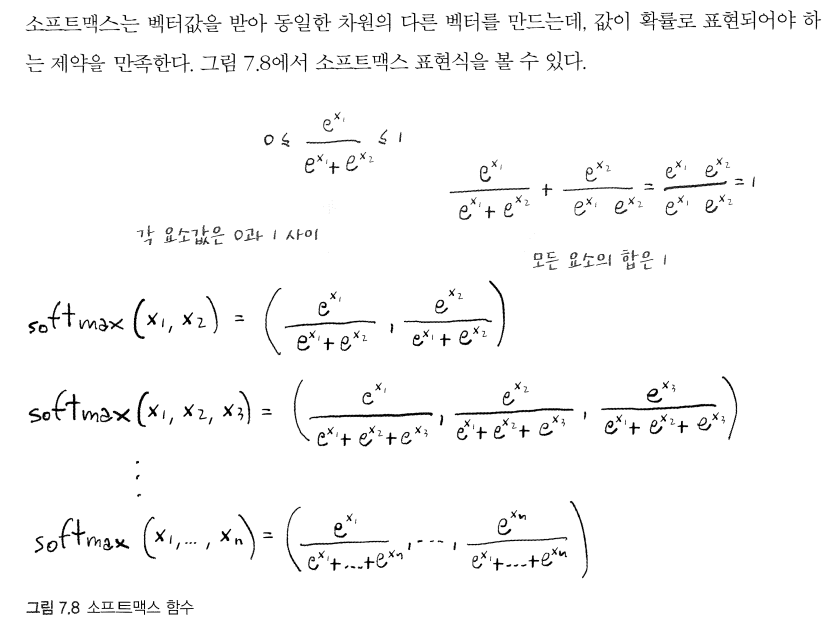

In [7]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
#입력 벡터로 테스트 해보자.
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

지금 경우는 배치를 다뤘던 때처럼 두 행에 두 개의 입력 벡터가 있다. 그래서 차원 1을 따라 nn.Softmax가 동작하도록 초기화 했다.

이제 모델의 끝에 소프트맥스를 추가하여 신경망이 확률을 출력하도록 만들었다.

In [11]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

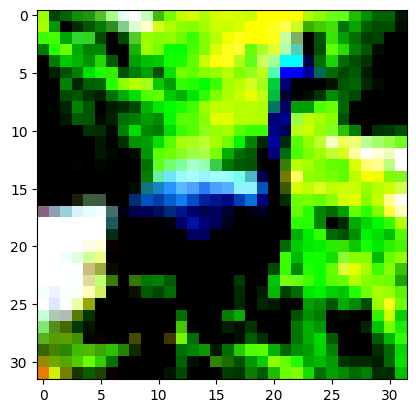

In [12]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
img_batch = img.view(-1).unsqueeze(0)

In [14]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [15]:
_, index = torch.max(out, dim=1)

index

tensor([1])

## 분류를 위한 손실값

In [16]:
#모델을 수정하여 nn.LogSoftmax를 출력 모듈로 사용하자.
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [17]:
loss = nn.NLLLoss()

In [18]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

## 분류기 훈련

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 8.307038
Epoch: 1, Loss: 5.457431
Epoch: 2, Loss: 3.882373
Epoch: 3, Loss: 3.154704
Epoch: 4, Loss: 11.443868
Epoch: 5, Loss: 7.831904
Epoch: 6, Loss: 0.055682
Epoch: 7, Loss: 7.118860
Epoch: 8, Loss: 6.412682
Epoch: 9, Loss: 5.462630
Epoch: 10, Loss: 6.324239
Epoch: 11, Loss: 8.132204
Epoch: 12, Loss: 4.478361
Epoch: 13, Loss: 0.397974
Epoch: 14, Loss: 3.924431
Epoch: 15, Loss: 6.191980
Epoch: 16, Loss: 4.834426
Epoch: 17, Loss: 6.948432
Epoch: 18, Loss: 0.884499
Epoch: 19, Loss: 10.726386
Epoch: 20, Loss: 8.787334
Epoch: 21, Loss: 5.266410
Epoch: 22, Loss: 7.096104
Epoch: 23, Loss: 4.407344
Epoch: 24, Loss: 6.470562
Epoch: 25, Loss: 10.756291
Epoch: 26, Loss: 16.045588
Epoch: 27, Loss: 13.241747
Epoch: 28, Loss: 8.135650
Epoch: 29, Loss: 9.221145
Epoch: 30, Loss: 11.256797
Epoch: 31, Loss: 13.286485
Epoch: 32, Loss: 14.590942
Epoch: 33, Loss: 19.243477
Epoch: 34, Loss: 7.613646
Epoch: 35, Loss: 8.939101
Epoch: 36, Loss: 5.921707
Epoch: 37, Loss: 7.737715
Epoch: 38, Lo

In [20]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

#DataLoader는 순회 가능하기 때문에 다음과 같은 새로운 훈련 코드의 루프 안에 바로 넣어 사용할 수 있다.

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.447263
Epoch: 1, Loss: 0.417204
Epoch: 2, Loss: 0.288800
Epoch: 3, Loss: 0.329748
Epoch: 4, Loss: 0.442465
Epoch: 5, Loss: 0.406243
Epoch: 6, Loss: 0.698463
Epoch: 7, Loss: 0.429398
Epoch: 8, Loss: 0.375769
Epoch: 9, Loss: 0.517260
Epoch: 10, Loss: 0.428689
Epoch: 11, Loss: 0.416207
Epoch: 12, Loss: 0.365555
Epoch: 13, Loss: 0.329109
Epoch: 14, Loss: 0.320614
Epoch: 15, Loss: 0.416643
Epoch: 16, Loss: 0.434464
Epoch: 17, Loss: 0.323721
Epoch: 18, Loss: 0.296406
Epoch: 19, Loss: 0.525408
Epoch: 20, Loss: 0.275151
Epoch: 21, Loss: 0.296652
Epoch: 22, Loss: 0.370118
Epoch: 23, Loss: 0.189625
Epoch: 24, Loss: 0.260521
Epoch: 25, Loss: 0.231848
Epoch: 26, Loss: 0.109705
Epoch: 27, Loss: 0.537064
Epoch: 28, Loss: 0.154275
Epoch: 29, Loss: 0.526165
Epoch: 30, Loss: 0.219033
Epoch: 31, Loss: 0.316020
Epoch: 32, Loss: 0.287425
Epoch: 33, Loss: 0.222993
Epoch: 34, Loss: 0.198543
Epoch: 35, Loss: 0.110400
Epoch: 36, Loss: 0.185364
Epoch: 37, Loss: 0.136970
Epoch: 38, Loss: 0.430

In [22]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999200


In [23]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.814000


In [24]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

In [25]:
#일반적으로 신경망의 마지막 계층에서는 nn.LogSoftmax 대신 손실값으로 nn.CrossEntropyLoss를 사용한다.
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

이번 장에서 우리는 데이터셋과 모델, 훈련 루프를 가지고 모델을 학습했다.


하지만 주어진 문제와 사용한 신경망 구조가 맞지 않아 모델이 일반적인 특징을 잡아내어 학습하지 못하고 오히려 훈련 데이터에 과적합됐다.


그래서 이미지 내 각 픽셀이 다른 모든 픽셀과 연관되는 모델을 만들었고, 공간상의 배치는 고려하지 않았다. 서로 가까이 있는 픽셀은 관련이 있다는 합리적인 가정을 해보았다. 따라서 우리가 훈련시킨 부류기는 평행이동에 대응할 수 없었다. 이것으로 검증셋에서 잘 동작하려면 원본 이미지를 평행이동시켜 만든 많은 복제본에 대해 동작하는 더 큰 용량의 모델이 필요하게 됐다.

현재 직면한 문제를 해결하려면 모델이 컨볼루션층을 사용하도록 변경해야 하며 이에 관해서는 다음 장에서 다룰 예정이다.